# Model Predictive Control

An entire marathon! Trying to make model predictive control (slightly more advanced than LQG) work. Main reference: https://ieeexplore-ieee-org.libproxy.berkeley.edu/stamp/stamp.jsp?tp=&arnumber=8511551

Steps:

1. Keck mirror finite-element analysis: find its $\omega_D, \omega_T, d$. Will just skip over this. 
2. Convert TF to SS and augment to make $C_i, B_i$.
3. Augment with turbulence and vibrations to make $A_i$ and $C_0$.
4. Pick $R_y, R_u, u_{max}$.
5. Solve the quadratic system!

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal, io, linalg
from cvxopt import solvers, matrix

from aberrations import *
from observer import *
from controller import *
from fractal_deriv import design_filt
from utils import *

f_sampling = 1000
rms = lambda data: np.sqrt(np.mean(data ** 2))
eps = 1e-8
process_noise = 0.01
measurement_noise = 0.06

N_delay = 2

In [2]:
# step 1: Keck mirror FEA results.

# These are completely random numbers. 

w_TT = 100
z_TT = 1

def make_impulse(w, z, T=np.arange(0, 1, 0.001)):
    num = [w**2]
    den = [1, 2 * w * z, w**2]
    tf = signal.TransferFunction(num, den)
    impulse = signal.impulse(tf, T=T)
    return impulse[0], impulse[1] / sum(impulse[1])

num, den = signal.cont2discrete(([w_TT ** 2], [1, 2 * w_TT * z_TT, w_TT ** 2]), dt=1/f_sampling)[:2]
A_TT, B_TT, C_TT, D_TT = signal.tf2ss(num, den)

/usr/local/lib/python3.7/site-packages/scipy/signal/filter_design.py:1619: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


In [3]:
size = 5000
N_vibe = 1
params = make_vibe_params(N=N_vibe)
vibe = make_1D_vibe_data(steps=size, N=N_vibe) + np.random.normal(0, process_noise * N_vibe, (size,))
pol = vibe
variances = np.array([process_noise] * N_vibe)
kfilter_vibe = make_kfilter_vibe(np.vstack((params[1:3])).T, variances)

Took 9 iterations to get steady-state covariance.


In [4]:
res, phy = kfilter_vibe.run(vibe + np.random.normal(0, measurement_noise, vibe.size), save_physics=True)

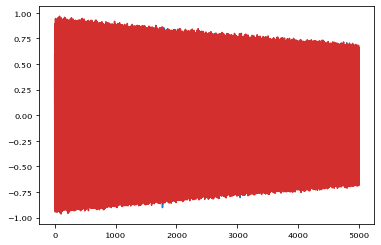

In [5]:
plt.plot(res)
plt.plot(vibe)

In [94]:
N = 2 * N_vibe + N_delay

In [96]:
A = np.zeros((N, N))
for i in range(2 * N_vibe):
    for j in range(2 * N_vibe):
        A[i][j] = kfilter_vibe.A[i][j]
        
for i in range(N_delay):
    A[2 * N_vibe + i][2 * N_vibe + i - 1] = 1

In [97]:
A

array([[ 0.32027792, -0.99982954,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ]])

In [99]:
B = np.zeros((N,1))
B[2 * N_vibe] = 1
C = np.zeros((1,N))
for i in range(N_vibe):
    C[0][2 * i] = 1

Q = np.zeros((N,N))
for i in range(N_vibe):
    Q[2 * i][2 * i] = variances[i]

R = np.array([measurement_noise])

In [100]:
kfilter = KFilter(np.zeros(N,), A, B, Q, C, R, has_input=True)

Took 31 iterations to get steady-state covariance.


In [101]:
N_frames = 5
y, u = 50, 1
R_y = np.identity(N_frames) * y
R_u = np.identity(N_frames) * u
C_0 = np.vstack(([kfilter.H] + [kfilter.H.dot(kfilter.A ** i) for i in range(1, N_frames)]))
D_0 = np.zeros((N_frames,N_frames))
for i in range(N_frames):
    for j in range(i):
        if i - j - 1 == 0:
            D_0[i][j] = kfilter.H.dot(kfilter.B)
        else:
            D_0[i][j] = kfilter.H.dot(kfilter.A ** (i - j - 1)).dot(kfilter.B)

In [102]:
kfilter.state = np.zeros(kfilter.A.shape[0],)
H2 = 2 * kfilter.state.T.dot(C_0.T.dot(R_y).dot(D_0))
H3 = D_0.dot(R_y).dot(D_0.T) + R_u
u_max = float(max(np.diff(pol[:5000])))
G = np.identity(N_frames)
G = np.vstack((np.identity(N_frames), -np.identity(N_frames)))
h = np.vstack([u_max] * (2 * N_frames))

In [103]:
kfilter.state = np.zeros(kfilter.A.shape[0],)
delay = 2

shifts = np.diff(pol)
res_control = np.zeros(pol.shape)
res_control[0] = 0
actions = np.zeros(pol.shape)
for i in range(size):
    try:
        if i > 0:
            res_control[i] = res_control[i - 1] + shifts[i - 1] + actions[i - 1]
        measurement = res_control[i - delay] + np.random.normal(0, 0.06)
        kfilter.update(measurement)
        
        if i < pol.size - N_frames - 1 and i % N_frames == 0:
            print(kfilter.state)
            H2 = 2 * kfilter.state.T.dot(C_0.T.dot(R_y).dot(D_0))
            solvers.options['show_progress'] = False
            solution = solvers.qp(matrix(H3), matrix(H2), matrix(G), matrix(h, tc='d'), solver='cvxopt')['x']
            # print(solution)
            for j in range(i, i + N_frames):
                actions[j] = solution[j - i] * 0
                
        kfilter.predict(actions[i - 1])
        
    except:
        print(i)
        raise

[-0.01085228 -0.00138632  0.00684427  0.00266805]
[-0.45519186 -0.53257612  0.10241204  0.38363442]
[-0.3360827  -0.03776528  0.31178863  0.18567813]
[ 0.21516619  0.06147661 -0.19580592 -0.22861847]
[-0.27806332 -0.54951051 -0.09639301  0.30284519]
[-0.29596008 -0.05149152  0.2484176   0.15775556]
[ 0.19397379  0.08862682 -0.17138574 -0.23863732]
[-0.23848487 -0.54528607 -0.12089287  0.29231147]
[-0.31350563 -0.06774708  0.26747595  0.16908232]
[ 0.22065671  0.15548568 -0.15814062 -0.29063675]
[-0.31184716 -0.56928888 -0.07374926  0.3149118 ]
[-0.34677958 -0.11518455  0.2630815   0.22103212]
[ 0.1902552   0.15216005 -0.13802663 -0.27767661]
[-0.27147572 -0.52620872 -0.09429058  0.26238155]
[-0.38336794 -0.12792107  0.29130431  0.23961828]
[ 0.21760697  0.15294341 -0.1620138  -0.2669799 ]
[-0.17646863 -0.50270548 -0.17873349  0.20559901]
[-0.33599989 -0.11435368  0.23624539  0.19557775]
[ 0.15952947  0.19850389 -0.09462063 -0.2969747 ]
[-0.20795622 -0.48648107 -0.12811136  0.20195334]


[ 0.19900774  0.14617281 -0.14708341 -0.27476693]
[-0.21112305 -0.42617355 -0.10218731  0.18040163]
[-0.3743168  -0.16499317  0.26226421  0.23488227]
[ 0.17289225  0.11934284 -0.12806142 -0.22681015]
[-0.2075183  -0.45556231 -0.1257133   0.19072146]
[-0.36475826 -0.13682498  0.26232237  0.22059458]
[ 0.17736122  0.14842045 -0.10405679 -0.23738677]
[-0.20059697 -0.47758929 -0.13952278  0.20256606]
[-0.42190016 -0.19010566  0.28517167  0.2773943 ]
[ 0.12182781  0.08665242 -0.07863644 -0.17333934]
[-0.13926802 -0.48891999 -0.19129455  0.20269914]
[-0.32044603 -0.20172173  0.19299226  0.24521894]
[ 0.16159686  0.1892181  -0.08853471 -0.26494507]
[-0.127597   -0.38923976 -0.16817742  0.12568236]
[-0.34741936 -0.2282245   0.19447012  0.25827165]
[ 0.1352622   0.20810328 -0.05354242 -0.2617213 ]
[-0.08322748 -0.46049591 -0.21782165  0.16166949]
[-0.40210368 -0.15998747  0.25078628  0.22099525]
[ 0.10538948  0.24611869  0.00326632 -0.27840634]
[-0.07962071 -0.35503188 -0.18551937  0.08217772]


[-0.40931905 -0.34545583  0.17839341  0.33729929]
[ 0.08084484  0.15913972  0.00450079 -0.15892626]
[ 0.00672975 -0.25765827 -0.22104707 -0.02269187]
[-0.39180472 -0.33718142  0.15942087  0.30830224]
[ 0.01479876  0.20200417  0.06182804 -0.19225176]
[ 0.00915887 -0.31586227 -0.23800811  0.01496782]
[-0.42202445 -0.35998793  0.17769209  0.3324229 ]
[ 0.0444652   0.211624    0.05220013 -0.1719362 ]
[ 0.03577439 -0.23458484 -0.23159345 -0.05037484]
[-0.43653733 -0.33689549  0.16765113  0.29464496]
[ 0.0359577   0.1546491   0.05417303 -0.12808763]
[-0.00205343 -0.25167164 -0.19492077 -0.017896  ]
[-0.41501479 -0.39527312  0.15086104  0.35318625]
[-0.01978694  0.16440151  0.08936485 -0.12894308]
[ 0.00559542 -0.26334322 -0.20258883 -0.00759781]
[-0.43198773 -0.46359442  0.12456361  0.39172833]
[-0.00896908  0.15500124  0.07585157 -0.11697639]
[ 0.10474266 -0.18690187 -0.28027661 -0.08917493]
[-0.4541769  -0.35825341  0.17973886  0.30064937]
[-0.07726216  0.14399901  0.16183185 -0.07996895]


[-0.04376202  0.11844878  0.09956251 -0.05594089]
[ 0.12539714 -0.10582081 -0.24155574 -0.15998618]
[-0.33308226 -0.37781073  0.0539124   0.26059034]
[-0.11802237  0.1176155   0.16259742 -0.05662824]
[ 0.06217067 -0.15440329 -0.19375702 -0.0850257 ]
[-0.37272856 -0.44473723  0.06453903  0.32933298]
[-0.05555691  0.1047921   0.1124709  -0.04689862]
[ 0.09783559 -0.11498837 -0.20234829 -0.12073171]
[-0.30829909 -0.40935493  0.0135142   0.2567368 ]
[-0.14045053  0.12308843  0.1837304  -0.03358101]
[ 0.08144776 -0.08887749 -0.17716016 -0.13147924]
[-0.33336643 -0.46820987  0.0208943   0.32213234]
[-0.17109934  0.01572505  0.17140409  0.04398409]
[ 0.14162817 -0.02316969 -0.20592214 -0.17557712]
[-0.35022376 -0.40532941  0.04631501  0.24957887]
[-0.18082116  0.06880208  0.2015363   0.0271369 ]
[ 0.14844372 -0.0143448  -0.19690957 -0.18244412]
[-0.2628049  -0.44714003 -0.02782107  0.27381591]
[-0.17451021  0.04014611  0.16925378  0.02196382]
[ 0.13102431 -0.01528576 -0.1779703  -0.18952605]


[-0.05086965 -0.30063144 -0.17784399  0.05355011]
[-0.40710488 -0.28261424  0.19787688  0.27496355]
[ 0.0001397   0.13103563  0.05202354 -0.1279381 ]
[-0.00487747 -0.25586892 -0.20050159  0.00574193]
[-0.32941648 -0.31132648  0.1239863   0.26505963]
[ 0.02488145  0.12307493  0.01597189 -0.14433768]
[-0.05657576 -0.25214596 -0.14205295  0.02670957]
[-0.39835789 -0.3499509   0.16152759  0.31556965]
[ 0.0184261   0.11456673  0.02420898 -0.11504638]
[-0.00894633 -0.28107956 -0.1964982   0.01934423]
[-0.37549386 -0.39351583  0.10481384  0.32521596]
[ 0.04015234  0.10748503  0.013065   -0.11152429]
[-0.01553112 -0.20113879 -0.16362582 -0.04688764]
[-0.38010413 -0.34621006  0.14081213  0.29905114]
[ 0.01362034  0.11573012  0.03085875 -0.11186366]
[-0.00211249 -0.18942734 -0.18413841 -0.05290449]
[-0.43116664 -0.37310629  0.16353528  0.30453006]
[-0.04896844  0.068004    0.09340796 -0.03218171]
[ 0.03427254 -0.17787503 -0.18801569 -0.06223092]
[-0.39961531 -0.42035605  0.12296218  0.35069755]


In [104]:
rms(pol[kfilter.iters:])

0.5784634868120981

In [105]:
rms(res_control[kfilter.iters:])

0.8256411878393454

(1e-10, 77.72103224400814)

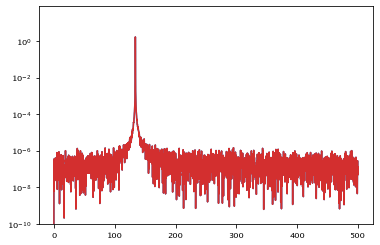

In [106]:
plt.semilogy(*signal.periodogram(pol, fs=f_sampling))
plt.semilogy(*signal.periodogram(res_control, fs=f_sampling))
# plt.semilogy(*signal.periodogram(actions, fs=f_sampling))
plt.ylim(1e-10)

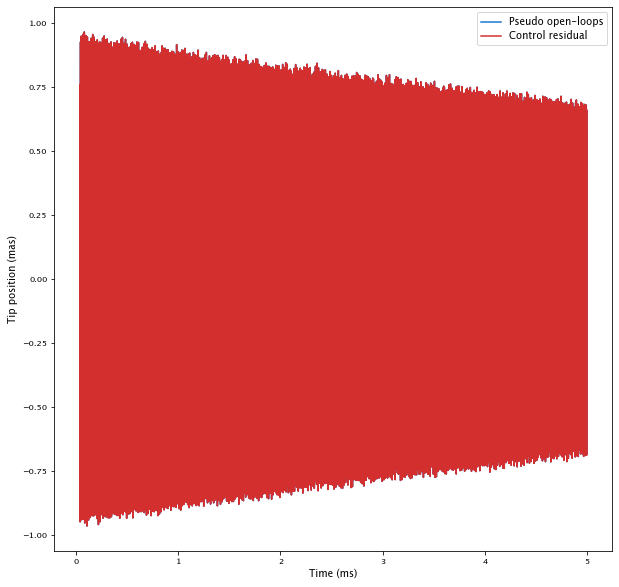

In [79]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(kfilter.iters / f_sampling, size / f_sampling, 1 / f_sampling), pol[kfilter.iters:], label='Pseudo open-loops')
plt.plot(np.arange(kfilter.iters / f_sampling, size / f_sampling, 1 / f_sampling), res_control[kfilter.iters:] - np.mean(res_control[kfilter.iters:]), label='Control residual')
plt.xlabel("Time (ms)")
plt.ylabel("Tip position (mas)")
plt.legend()
plt.show()